## Binary classification in pytorch example

### Example source 

Example is based on - https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

This example will be revised in 4 ways:
1. models are built using `torch.nn.Sequential` instead of the defining model classes as done in the example
2. instead of comparing wide vs. deep networks, this compares using relu vs. sigmoid activation functions in the hidden layer
3. models will only have 100 units in the hidden layer or ~6k parameters which is a little over half the number of parameters in the original example
4. model training function paramerizes batch size and number of epochs

### Sonar data source

Dataset is taken from https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks

In [1]:
import numpy as np
import pandas as pd

file_path = "D:\\Sync\\ds_ml\\Data Camp\\DeepLearning, NLP, LLMs\\Introduction to Deep Learning with PyTorch\\data\\sonar.csv"
df_sonar = pd.read_csv(file_path, header=None)
X = df_sonar.iloc[:, 0:60]  # 60 features
y = df_sonar.iloc[:, 60]  # last column are the labels
print(y.head())
print(y.tail())

0    R
1    R
2    R
3    R
4    R
Name: 60, dtype: object
203    M
204    M
205    M
206    M
207    M
Name: 60, dtype: object


In [2]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
print(encoder.classes_)
print(y[:5], y[-5:])  # 1 = R, 0 = M

['M' 'R']
[1 1 1 1 1] [0 0 0 0 0]


In [3]:
import torch
# convert the inputs and labels to torch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)  # make single col vector (N x 1)

In [4]:
print(X.shape, y.shape)  # torch.Size([208, 60]) torch.Size([208, 1])

torch.Size([208, 60]) torch.Size([208, 1])


In [5]:
import torch.nn as nn

# depart from example in two important ways:
# 1) use the more recent way to specify a model with Sequential()
# 2) compare hidden layer activation functions instead of wide vs. deep
num_inputs = 60  # this will be 1500 for the tweets model
num_outputs = 1
h1 = 100  # number of units in to single hidden layer

# use relu for hidden layer
model_h_relu = nn.Sequential(
    nn.Linear(num_inputs, h1),
    nn.ReLU(),
    nn.Linear(h1, num_outputs),
    nn.Sigmoid()
)

# use sigmoid for hidden layer
model_h_sigmoid = nn.Sequential(
    nn.Linear(num_inputs, h1),
    nn.Sigmoid(),
    nn.Linear(h1, num_outputs),
    nn.Sigmoid()
)

# both models have the same number of parameters
total_params = 0
for parameter in model_h_relu.parameters():
    total_params += parameter.numel()
print(f"both models have {total_params} total parameters (weights and biases)")

both models have 6201 total parameters (weights and biases)


In [6]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm  # creates a progress bar

def model_train(model, X_train, y_train, X_val, y_val,
                n_epochs=250,  batch_size=10):
    """
    Trains a model over n_epochs using mini-batch gradient descent and returns the best
    accuracy
    
    Args:
    model (torch.nn.modules.container.Sequential): pytorch model built with Sequential class
    X_train (): training partition of feature tensor
    y_train (): training partition of labels tensor
    X_val (): validation partition of feature tensor
    y_val (): validation partition of labels tensor
    n_epochs (int): number of passes through the training data to make while training
    batch_size (int): number of samples in a (mini) batch

    Returns:
    Accuracy of the best model
    """
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None
    # mark out the start of each batch
    batch_starts = torch.arange(0, len(X_train), batch_size)

    for epoch in range(n_epochs):
        model.train()   # put model in training mode
        with tqdm.tqdm(batch_starts, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for batch in bar:
                # take a batch
                X_batch = X_train[batch:batch+batch_size]
                y_batch = y_train[batch:batch+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()  # reset to zero for each batch, otherwise accumulates
                loss.backward()
                # update the weights
                optimizer.step()
                # sum up the correct predictions
                acc = (y_pred.round() == y_batch).float().mean()
                # report progress
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy after each epoch
        model.eval()
        y_pred = model(X_val)  # validation prediction
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return(best_acc)

In [7]:
# compare these 2 models with 5-fold CV
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: hold out theh test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
# define 5-fold cv test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# run CV on with the training data
cv_scores_relu = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_relu
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"ReLU accuracy: {acc:.4f}")
    cv_scores_relu.append(acc)

cv_scores_sigmoid = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = model_h_sigmoid
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"sigmoid accuracy: {acc:.4f}")
    cv_scores_sigmoid.append(acc)

# compare model performance
relu_acc = np.mean(cv_scores_relu)
relu_std = np.std(cv_scores_relu)
sigmoid_acc = np.mean(cv_scores_sigmoid)
sigmoid_std = np.std(cv_scores_sigmoid)
print(f"ReLU accuracy: {relu_acc*100:.2f}% +- {2*relu_std*100}%")
print(f"sigmoid accuracy: {sigmoid_acc*100:.2f}% +- {2*sigmoid_std*100}%")

ReLU accuracy: 0.7931
ReLU accuracy: 0.9655
ReLU accuracy: 0.8276
ReLU accuracy: 0.8276
ReLU accuracy: 0.8276
sigmoid accuracy: 0.8276
sigmoid accuracy: 0.8621
sigmoid accuracy: 0.7586
sigmoid accuracy: 0.8966
sigmoid accuracy: 0.8276
ReLU accuracy: 84.83% +- 12.024545961752747%
sigmoid accuracy: 83.45% +- 9.14931000198664%


Retrain a ReLU model
Final model accuracy: 73.02%
[2.160e-02 2.150e-02 2.730e-02 1.390e-02 3.570e-02 7.850e-02 9.060e-02
 9.080e-02 1.151e-01 9.730e-02 1.203e-01 1.102e-01 1.192e-01 1.762e-01
 2.390e-01 2.138e-01 1.929e-01 1.765e-01 7.460e-02 1.265e-01 2.005e-01
 1.571e-01 2.605e-01 5.386e-01 8.440e-01 1.000e+00 8.684e-01 6.742e-01
 5.537e-01 4.638e-01 3.609e-01 2.055e-01 1.620e-01 2.092e-01 3.100e-01
 2.344e-01 1.058e-01 3.830e-02 5.280e-02 1.291e-01 2.241e-01 1.915e-01
 1.587e-01 9.420e-02 8.400e-02 6.700e-02 3.420e-02 4.690e-02 3.570e-02
 1.360e-02 8.200e-03 1.400e-02 4.400e-03 5.200e-03 7.300e-03 2.100e-03
 4.700e-03 2.400e-03 9.000e-04 1.700e-03] -> [0.8658148] (expected [1.])
[0.0654 0.0649 0.0737 0.1132 0.2482 0.1257 0.1797 0.0989 0.246  0.3422
 0.2128 0.1377 0.4032 0.5684 0.2398 0.4331 0.5954 0.5772 0.8176 0.8835
 0.5248 0.6373 0.8375 0.6699 0.7756 0.875  0.83   0.6896 0.3372 0.6405
 0.7138 0.8202 0.6657 0.5254 0.296  0.0704 0.097  0.3941 0.6028 0.3521
 0.3924 0.4808 0.4602 0.4

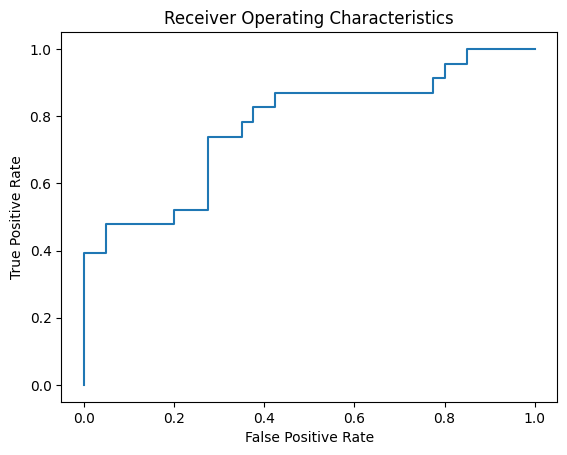

In [8]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# rebuild model with full set of training data
if relu_acc > sigmoid_acc:
    print("Retrain a ReLU model")
    model = model_h_relu
else:
    print("Retrain a sigmoid model")
    model = model_h_sigmoid
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")
 
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()